In [13]:
import pandas as pd
import seaborn as sns
import numpy as np
from tqdm import tqdm
import re
import json
import os

if os.path.exists('data/acled_preprocessed.csv'):
    print("Preprocessed dataset found. Loading...")
    df = pd.read_csv('data/acled_preprocessed.csv')
else:
    df = pd.read_csv('data/acled.csv')
    df['event_date'] = pd.to_datetime(df['event_date'])

    def add_future_fatalities(data, timeframe_months):
        print("Converting 'event_date' to datetime...")
        data['event_date'] = pd.to_datetime(data['event_date'])
        
        print("Sorting data by 'admin1' and 'event_date' (descending)...")
        data = data.sort_values(by=['admin1', 'event_date'], ascending=[True, False]).reset_index(drop=True)
        
        days_in_timeframe = timeframe_months * 30  # Approximate months as 30 days
        print(f"Applying rolling sum calculation with a {days_in_timeframe}-day timeframe...")
        
        def calculate_rolling_sum_excluding_current(group):
            group['fatalities'] = group['fatalities'].astype(int)
            group['shifted_fatalities'] = group['fatalities'].shift(-1)
            group['future_fatalities'] = group.rolling(
                on='event_date',
                window=f'{days_in_timeframe}D',
                min_periods=1
            )['shifted_fatalities'].sum()
            return group

        print("Processing groups by 'admin1'...")
        results = []
        for admin1, group in tqdm(data.groupby('admin1')):
            results.append(calculate_rolling_sum_excluding_current(group))
        
        print("Concatenating results...")
        data = pd.concat(results).reset_index(drop=True)
        
        print("Replacing missing values with -1...")
        data['future_fatalities'] = data['future_fatalities'].fillna(-1).astype(int)

        return data

    def add_past_events_and_fatalities(data, timeframe_months):
        print("Converting 'event_date' to datetime...")
        data['event_date'] = pd.to_datetime(data['event_date'])
        
        print("Sorting data by 'admin1' and 'event_date' in ascending order...")
        data = data.sort_values(by=['admin1', 'event_date'], ascending=[True, True]).reset_index(drop=True)
        
        days_in_timeframe = timeframe_months * 30  # Approximate months as 30 days
        print(f"Timeframe for rolling calculations is set to {days_in_timeframe} days.")
        
        def calculate_past_metrics(group):
            group['num_events'] = group.rolling(
                on='event_date',
                window=f'{days_in_timeframe}D',
                min_periods=1
            )['event_date'].count() - 1
            group['past_fatalities'] = group.rolling(
                on='event_date',
                window=f'{days_in_timeframe}D',
                min_periods=1
            )['fatalities'].sum() - group['fatalities']
            group['num_events'] = group['num_events'].fillna(0).clip(lower=0).astype(int)
            group['past_fatalities'] = group['past_fatalities'].fillna(0).clip(lower=0).astype(int)
            return group

        print("Grouping data by 'admin1' and applying rolling calculations...")
        results = []
        for admin1, group in tqdm(data.groupby('admin1')):
            results.append(calculate_past_metrics(group))
        
        print("Concatenating all processed groups into a single dataframe...")
        data = pd.concat(results).reset_index(drop=True)
        print("Finished adding 'num_events' and 'past_fatalities'.")
        
        return data

    print("Classifying crowd size...")
    def classify_crowd_size(tag):
        if isinstance(tag, str) and re.search(r'\d', tag):
            value = re.search(r'\d[\d,]*', tag).group()
            value = int(value.replace(',', ''))
            if value < 100:
                return "dozens"
            elif value < 1000:
                return "hundreds"
            else:
                return "large"
        elif isinstance(tag, str) and "no report" in tag:
            return "no report"
        return "other tag"

    df["crowd_size"] = df["tags"].apply(classify_crowd_size)

    print("Adding past events and fatalities...")
    df = add_past_events_and_fatalities(df, timeframe_months=6)

    print("Adding future fatalities...")
    df = add_future_fatalities(df, timeframe_months=6)

    print("One-hot encoding categorical columns...")
    df = pd.get_dummies(df, columns=["sub_event_type", "inter1", "region"])

    print("Tagging rows with no info...")
    df["no_info"] = df["tags"].apply(lambda x: 1 if pd.isna(x) or x == "crowd size=no report" else 0)

    with open('data/keywords.json') as f:
        words = json.load(f)

    keywords = words['tags']

    print("Creating columns for keywords...")
    for keyword in keywords:
        df[keyword] = df["tags"].apply(lambda x: 1 if isinstance(x, str) and keyword in x else 0)
        
    escalation_words = words['escalation']

    print("Counting escalation words...")
    escalation_pattern = '|'.join(re.escape(word.lower()) for word in escalation_words)

    def count_escalation_words_vectorized(notes_series, pattern):
        return notes_series.str.lower().str.findall(pattern).apply(len)

    df['escalation_count'] = count_escalation_words_vectorized(df['notes'], escalation_pattern)

    print("Saving the updated dataset...")
    columns_of_interest = words['columns']
    df = df[columns_of_interest]

    print("Removing rows with missing 'future_fatalities'...")
    df = df[df.future_fatalities != -1]

    print("Dataset preprocessing complete!")
    df.to_csv('data/acled_preprocessed.csv', index=False)

Preprocessed dataset found. Loading...


In [15]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.model_selection import train_test_split

In [21]:
X = np.array(df.drop(columns='future_fatalities'))
y = np.array(df['future_fatalities'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
# use a MLPClassifier to predict if fatalities_sum is 0 or not
clf = MLPClassifier()
clf.fit(X_train, y_train == 0)
print("Accuracy of predicting if fatalities_sum is 0:", clf.score(X_test, y_test == 0))

Accuracy of predicting if fatalities_sum is 0: 0.9240635861983512


### Regression Below

In [ ]:

# then use a RandomForestRegressor to predict the fatalities_sum if it is not 0
clf = RandomForestClassifier()
clf.fit(X_train, y_train == 0)
reg = RandomForestRegressor()
reg.fit(X_train[y_train != 0], y_train[y_train != 0])

y_pred = np.zeros(len(y_test))
y_pred[y_test == 0] = clf.predict(X_test[y_test == 0])
y_pred[y_test != 0] = reg.predict(X_test[y_test != 0])

In [ ]:
# get R^2 score
from sklearn.metrics import r2_score

from sklearn.metrics import root_mean_squared_error
r2_score(y_test, y_pred), root_mean_squared_error(y_test, y_pred)

(0.33917499852851807, 1909.940384359134)

1919.754568052805

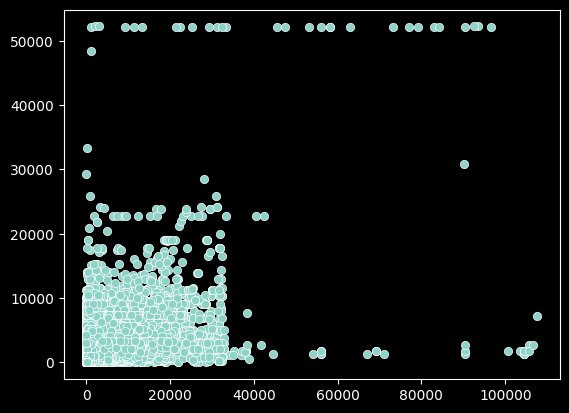

75.03723284895297

<Axes: >

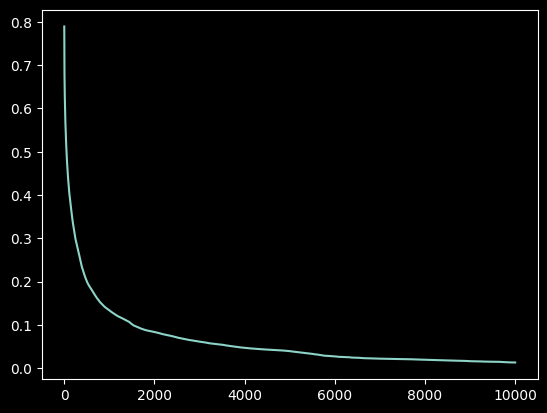